# Final Experiments - Random Single-label CNNText

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
import random
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [3]:
print(len(top10s[0]))
idx = random.sample(range(len(top10s[0])), 5)
print(np.array(top10s[1])[idx])

1159
['greedy' 'greedy' 'data structures' 'brute force' 'dp']


## CNN Experiments

In [4]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, class_num, channel_in=1, 
                 kernel_sizes=[3, 4, 5], kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(embed_num, embed_dim)
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

### 5-class

In [6]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

np.random.seed(142)
print(yall[0])
np.random.shuffle(yall)
print(yall[0])

Checkpoint reached: raw data cleaned.
multiclass classification.
[0 0 0 1 0]
[1 0 0 0 0]


In [7]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                           f'{i}_rn_cnntext5s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

epoch      trn_loss   val_loss   accuracy                  
    0      0.167671   0.164751   0.163636  
    1      0.161853   0.160227   0.181818                  
    2      0.15596    0.160061   0.2                       
    3      0.14853    0.160531   0.163636                  
    4      0.139107   0.162122   0.163636                  
    5      0.126822   0.165694   0.181818                  
    6      0.111163   0.170109   0.236364                  
    7      0.092539   0.170613   0.2                        
    8      0.073058   0.174314   0.2                        
    9      0.055512   0.176639   0.218182                   

0.23636363636363636


epoch      trn_loss   val_loss   accuracy                  
    0      0.166851   0.162334   0.236364  
 75%|███████▌  | 12/16 [00:01<00:00, 12.00it/s, loss=0.162]


KeyboardInterrupt: 

In [8]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-random_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-random_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.30      0.15      0.20       550
             dp       0.24      0.65      0.35       550
         greedy       0.25      0.15      0.19       550
 implementation       0.20      0.12      0.15       550
           math       0.30      0.19      0.23       550

    avg / total       0.26      0.25      0.22      2750

0.25018181818181817
0.2232798953216244
Normalized confusion matrix
[[0.14909 0.48727 0.12364 0.12    0.12   ]
 [0.05455 0.64727 0.10182 0.11091 0.08545]
 [0.09273 0.53636 0.14727 0.13818 0.08545]
 [0.10182 0.50909 0.12727 0.12182 0.14   ]
 [0.09818 0.49818 0.09091 0.12727 0.18545]]
0.6472727272727272


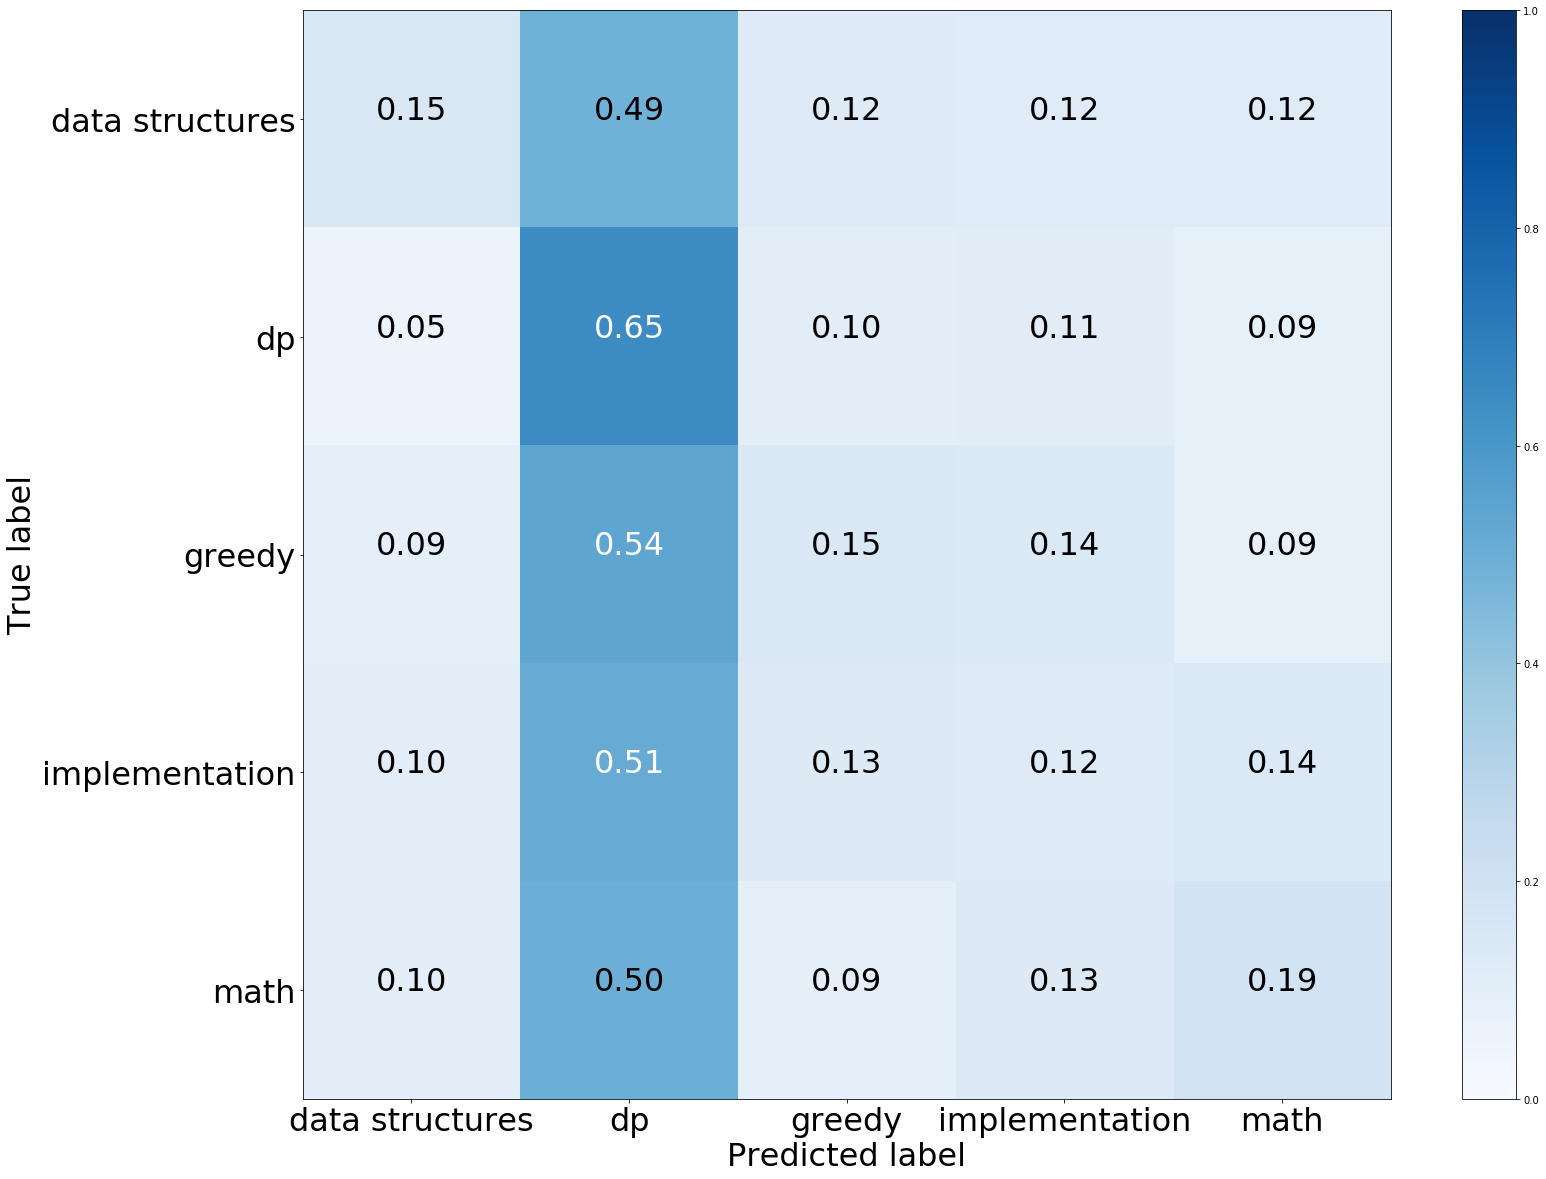

In [9]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)

### 10-class

In [11]:
trunner = TextRunner([None], top10s[0], top10s[1], 'top10s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

np.random.seed(142)

print(yall[0])
np.random.shuffle(yall)
print(yall[0])

Checkpoint reached: raw data cleaned.
multiclass classification.
[0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]


In [12]:
runs = 5
out_dim = 10

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                               f'{i}_rn_cnntext10s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

epoch      trn_loss   val_loss   accuracy                   
    0      0.084073   0.086436   0.310345  
    1      0.081431   0.085957   0.310345                   
    2      0.078052   0.086757   0.310345                   
    3      0.072454   0.087683   0.310345                   
    4      0.062929   0.08793    0.310345                   
    5      0.049363   0.090928   0.301724                   
    6      0.03515    0.092916   0.310345                   
    7      0.023498   0.097074   0.215517                   
    8      0.020045   0.099181   0.224138                   
    9      0.02331    0.112775   0.318966                   

0.31896551724137934


epoch      trn_loss   val_loss   accuracy                   
    0      0.084672   0.080538   0.387931  
 12%|█▏        | 4/33 [00:00<00:02, 12.10it/s, loss=0.084] 


KeyboardInterrupt: 

In [13]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-random_10s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-random_10s.pkl', 'rb'))

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            brute force       0.00      0.00      0.00       325
constructive algorithms       0.12      0.00      0.01       320
        data structures       0.67      0.00      0.01       550
                     dp       0.27      0.01      0.01       720
        dfs and similar       0.00      0.00      0.00       180
               geometry       0.00      0.00      0.00       245
                 greedy       0.73      0.02      0.04       605
         implementation       0.35      1.00      0.52      2025
                   math       0.30      0.01      0.02       660
                strings       0.00      0.00      0.00       165

            avg / total       0.34      0.35      0.19      5795

0.3523727351164797
0.1905311054369027
Normalized confusion matrix
[[0.      0.      0.      0.00615 0.      0.      0.      0.98769 0.00615 0.     ]
 [0.      0.00313 0.      0.00313 0.      0.      0.      0.98125 0.

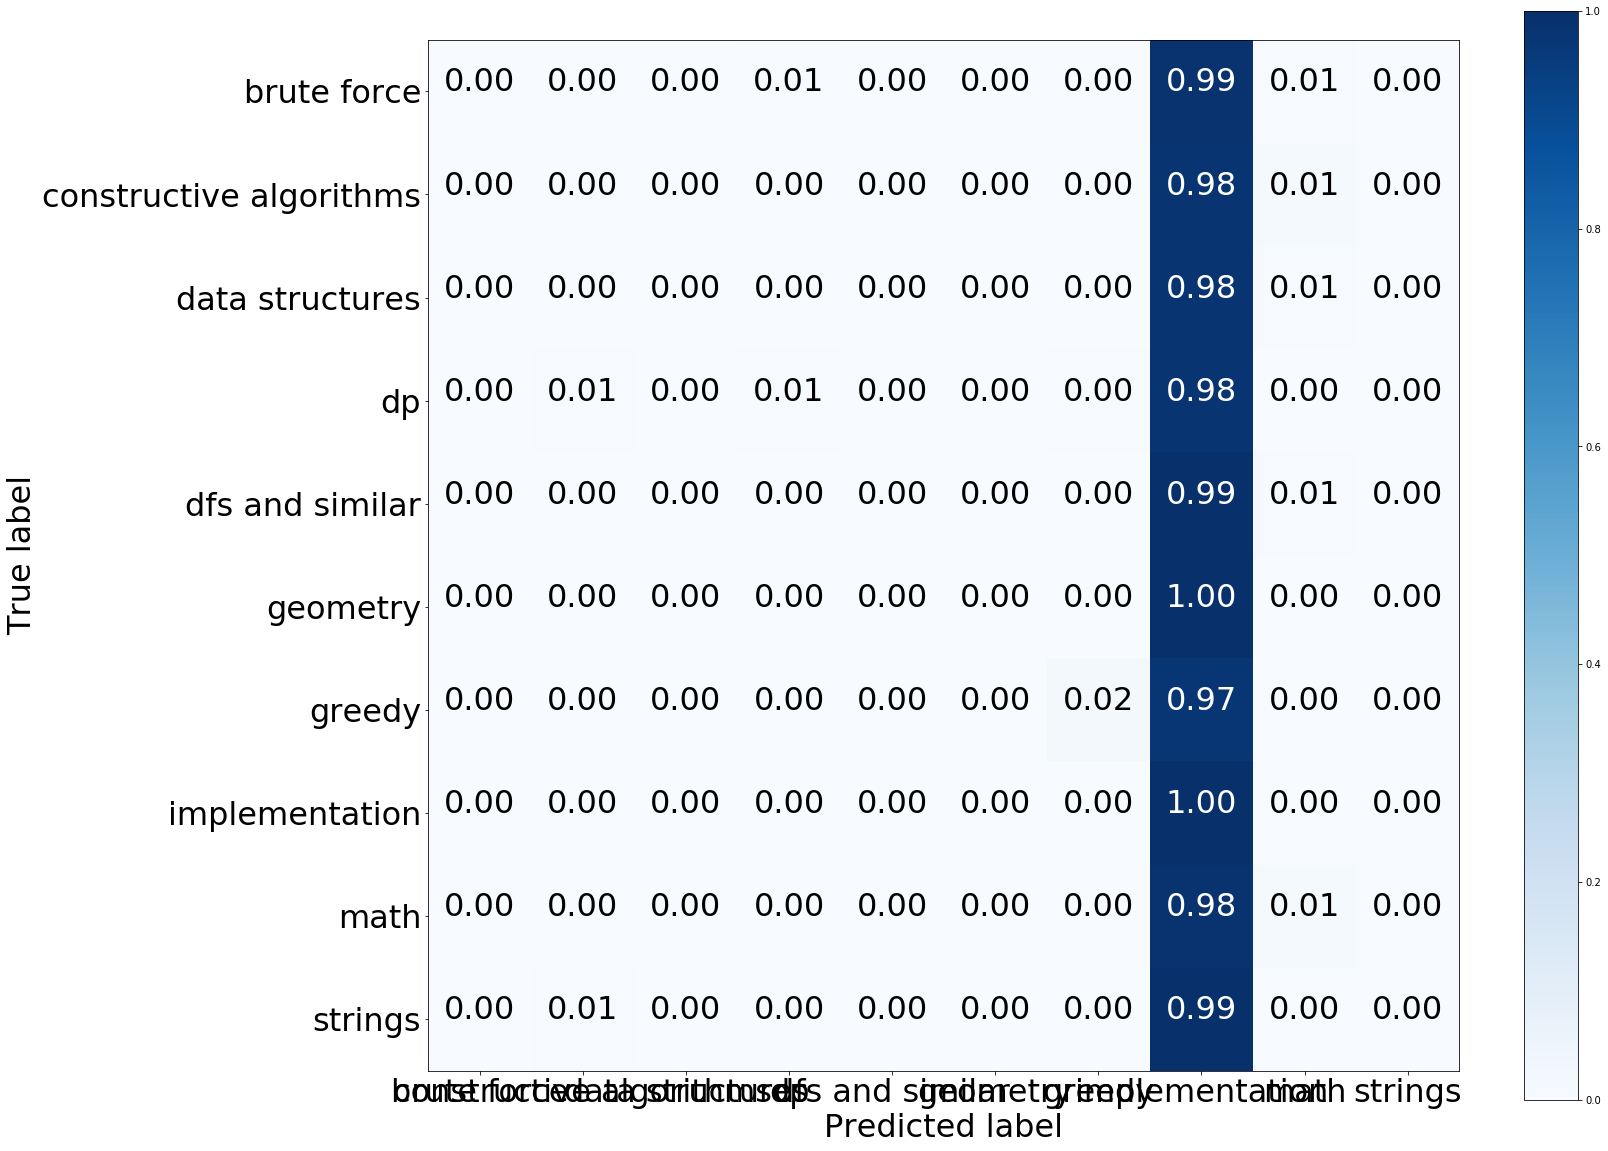

In [15]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)